# 🤖 Supervised Learning for Oil Well Fault Detection

## What is Supervised Classification?

Supervised learning uses labeled training data to predict categories for new data.

**Key Components:**
- **Training Data**: Examples with known answers (features + labels)
- **Features**: Sensor measurements (input)
- **Labels**: Fault types 0-9 (output)
- **Model**: Algorithm that learns patterns
- **Evaluation**: How well the model performs

## Our Problem: 3W Oil Well Classification

**Goal**: Predict oil well fault types from sensor data

**Input**: Time series from sensors (P-PDG, P-TPT, T-TPT)
**Output**: Fault classes (0=normal, 1-9=different faults)
**Challenge**: Multiple classes, imbalanced data, high dimensions

In [1]:
# ============================================================
# LOAD 3W DATASET
# ============================================================

import sys
import numpy as np

# Add src directory to path
sys.path.append("src")
from src import config
from src.supervised_classification import load_3w_data

# Load dataset using utility function
(train_dfs, train_classes, train_fold_info,
 test_dfs, test_classes, test_fold_info) = load_3w_data(config, verbose=True)

Loading 3W Dataset for Classification
Found 3 folds
✅ Data loaded successfully!
   Training windows: 197259
   Test windows: 30177
   Window shape: (300, 4)


# 📊 Classification Configuration

## Class Selection

Choose which fault types to analyze:

```python
selected_classes = [3, 4, 8]  # Focus on specific faults
selected_classes = [1, 2, 3, 4, 5]  # Early fault types  
selected_classes = None  # All fault types (exclude normal operation)
```

## Key Features

1. **Configurable Classes**: Select specific fault types for focused analysis
2. **Cross-Fold Validation**: Test model consistency across data splits  
3. **Class Balancing**: Handle imbalanced data with augmentation
4. **Multiple Algorithms**: Compare different ML approaches
5. **Performance Analysis**: Detailed metrics and visualizations

In [2]:
# ============================================================
# CONFIGURE CLASSIFICATION
# ============================================================

from src.supervised_classification import validate_configuration

# Configuration
selected_classes = [3, 4, 8]  # Choose fault types to analyze
balance_test = False  # Keep original test distribution
min_test_samples_per_class = 300

print("Classification Configuration:")
print("=" * 35)

# Verify data availability
if not (train_dfs and test_dfs):
    print("❌ No data available. Run the data loading cell first.")
else:
    print(f"✅ Data ready: {len(train_dfs)} train, {len(test_dfs)} test windows")
    
    # Validate configuration
    config_valid = validate_configuration(selected_classes, test_classes, verbose=True)
    
    # Check fold information
    fold_available = (test_fold_info is not None and len(test_fold_info) == len(test_dfs))
    if fold_available:
        unique_folds = sorted(set(test_fold_info))
        print(f"✅ Fold information: {len(unique_folds)} folds detected")
    else:
        print("⚠️ No fold information available")

Classification Configuration:
✅ Data ready: 197259 train, 30177 test windows
Selected classes: [3, 4, 8]
⚠️ Missing classes: {8, 3, 4}
✅ Fold information: 3 folds detected


In [3]:
# ============================================================
# TRAIN CLASSIFICATION MODELS
# ============================================================

from src.supervised_classification import enhanced_fold_analysis
from tqdm import tqdm

if not (train_dfs and test_dfs):
    print("❌ No data available for training")
    supervised_classifier = None
else:
    print("🚀 Training Classification Models")
    print("=" * 40)
    
    models_to_train = ["Decision Tree", "Random Forest", "Linear SVM", "RBF SVM", 
                      "Simple Neural Network", "Deep Neural Network", "Regularized Neural Network"]
    
    print(f"Training {len(models_to_train)} algorithms...")
    
    # Train models with progress bar
    with tqdm(total=len(models_to_train), desc="Training", unit="model") as pbar:
        try:
            classifier = enhanced_fold_analysis(
                train_dfs=train_dfs,
                train_classes=train_classes,
                test_dfs=test_dfs,
                test_classes=test_classes,
                train_fold_info=(train_fold_info if fold_available else None),
                test_fold_info=(test_fold_info if fold_available else None),
                balance_classes=True,
                balance_strategy="combined",
                max_samples_per_class=1000,
                balance_test=balance_test,
                min_test_samples_per_class=min_test_samples_per_class,
                selected_classes=selected_classes,
                verbose=False,
            )
            pbar.update(len(models_to_train))
            supervised_classifier = classifier
            print("✅ Training completed successfully!")
            
        except Exception as e:
            print(f"❌ Training failed: {e}")
            supervised_classifier = None

🚀 Training Classification Models
Training 7 algorithms...


Training:   0%|          | 0/7 [00:00<?, ?model/s]

⚖️ Class Balancing Strategy: combined
   • Original class distribution: {np.int16(3): 12082, np.int16(4): 2373, 8: 8922}
📉 Random Undersampling (strategy: auto)
   • Original class distribution: {np.int16(3): 12082, np.int16(4): 2373, 8: 8922}
   • Target class counts: {np.int16(3): 8922, np.int16(4): 8922, 8: 8922}
   • Final class distribution: {np.int16(3): 8922, np.int16(4): 2373, 8: 8922}
   • Samples: 23377 → 20217
📈 Random Oversampling (strategy: auto)
   • Original class distribution: {np.int16(3): 8922, np.int16(4): 2373, 8: 8922}
   • Target class counts: {np.int16(3): 8922, np.int16(4): 8922, 8: 8922}
   • Final class distribution: {np.int16(3): 8922, np.int16(4): 8922, 8: 8922}
   • Samples: 20217 → 26766
⚖️ Class Balancing Strategy: combined
   • Original class distribution: {np.int16(3): 12056, np.int16(4): 2373, 8: 8174}
📉 Random Undersampling (strategy: auto)
   • Original class distribution: {np.int16(3): 12056, np.int16(4): 2373, 8: 8174}
   • Target class counts: {np

Training: 100%|██████████| 7/7 [00:58<00:00,  8.34s/model]

Complete Model Performance Comparison:
Model                     Train Acc    Test Acc     Train Time   Overfitting 
--------------------------------------------------------------------------------
Decision Tree             0.959        0.835        1.628        0.124       
Random Forest             0.986        0.896        0.575        0.090       
Linear SVM                0.791        0.788        0.197        0.003       
RBF SVM                   0.862        0.802        0.070        0.060       
Simple Neural Network     0.930        0.787        1.818        0.143       
Deep Neural Network       0.950        0.812        7.859        0.138       
Regularized Neural Network 0.948        0.824        4.654        0.123       

Model Rankings:
   Best Test Accuracy: Random Forest (0.896)
   ⚡ Fastest Training: RBF SVM (0.070s)
   Least Overfitting: Linear SVM (gap: 0.003)

📋 Detailed Classification Report (Random Forest):
              precision    recall  f1-score   support

 

In [4]:
# ============================================================
# RESULTS SUMMARY
# ============================================================

if supervised_classifier is not None and hasattr(supervised_classifier, 'results'):
    results = supervised_classifier.results
    
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    
    # Performance table
    print(f"{'Model':<25} {'Train Acc':<10} {'Test Acc':<10} {'Time (s)':<8}")
    print("-" * 53)
    
    for result in results:
        print(f"{result['model_name']:<25} "
              f"{result['train_accuracy']:<10.3f} "
              f"{result['test_accuracy']:<10.3f} "
              f"{result['training_time']:<8.2f}")
    
    # Best model
    best_model = max(results, key=lambda x: x['test_accuracy'])
    print(f"\n🏆 Best Model: {best_model['model_name']}")
    print(f"   Test Accuracy: {best_model['test_accuracy']:.3f}")
    
else:
    print("❌ No results available. Run training first.")

📊 MODEL PERFORMANCE SUMMARY
Model                     Train Acc  Test Acc   Time (s)
-----------------------------------------------------
Decision Tree             0.959      0.835      1.63    
Random Forest             0.986      0.896      0.57    
Linear SVM                0.791      0.788      0.20    
RBF SVM                   0.862      0.802      0.07    
Simple Neural Network     0.930      0.787      1.82    
Deep Neural Network       0.950      0.812      7.86    
Regularized Neural Network 0.948      0.824      4.65    

🏆 Best Model: Random Forest
   Test Accuracy: 0.896


In [5]:
# ============================================================
# CROSS-FOLD VALIDATION RESULTS
# ============================================================

if (supervised_classifier is not None and 
    hasattr(supervised_classifier, 'fold_results') and 
    supervised_classifier.fold_results):
    
    print("📈 CROSS-FOLD VALIDATION")
    print("=" * 35)
    
    fold_results = supervised_classifier.fold_results
    fold_names = sorted(fold_results.keys())
    
    if fold_names and results:
        model_names = [r['model_name'] for r in results]
        
        # Table header
        header = f"{'Fold':<12}"
        for model_name in model_names:
            short_name = model_name.replace(" Neural Network", " NN").replace("Random Forest", "RF")[:10]
            header += f"{short_name:<12}"
        print(f"\n{header}")
        print("-" * len(header))
        
        # Fold results
        for fold in fold_names:
            row = f"{fold:<12}"
            for model_name in model_names:
                accuracy = fold_results[fold].get(model_name, 0.0)
                row += f"{accuracy:<12.3f}"
            print(row)
        
        # Calculate averages
        print("-" * len(header))
        avg_row = f"{'Average':<12}"
        for model_name in model_names:
            accuracies = [fold_results[fold].get(model_name, 0.0) for fold in fold_names]
            avg_accuracy = np.mean(accuracies) if accuracies else 0.0
            avg_row += f"{avg_accuracy:<12.3f}"
        print(avg_row)
        
        # Store for later analysis
        fold_accuracies = fold_results
    
else:
    print("❌ Cross-fold validation not available")

📈 CROSS-FOLD VALIDATION

Fold        Decision T  RF          Linear SVM  RBF SVM     Simple NN   Deep NN     Regularize  
------------------------------------------------------------------------------------------------
fold_1      0.907       0.956       0.862       0.918       0.878       0.878       0.863       
fold_2      0.839       0.916       0.576       0.760       0.820       0.827       0.825       
fold_3      0.860       0.926       0.734       0.872       0.873       0.848       0.833       
------------------------------------------------------------------------------------------------
Average     0.869       0.933       0.724       0.850       0.857       0.851       0.840       


# 🌳 Algorithm Analysis

## Decision Trees and Random Forest

In [6]:
# ============================================================
# DECISION TREES ANALYSIS
# ============================================================

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    tree_models = [r for r in results if "Tree" in r["model_name"] or "Forest" in r["model_name"]]

    if tree_models:
        print("🌳 Tree-Based Models Performance")
        print("-" * 35)
        
        for result in tree_models:
            print(f"\n{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Training Time: {result['training_time']:.2f}s")

        # Best tree model
        best_tree = max(tree_models, key=lambda x: x["test_accuracy"])
        print(f"\n🏆 Best Tree Model: {best_tree['model_name']} ({best_tree['test_accuracy']:.3f})")
    else:
        print("❌ No tree-based models found")
else:
    print("❌ Run classification first")

🌳 Tree-Based Models Performance
-----------------------------------

Decision Tree:
   Training Accuracy: 0.959
   Test Accuracy: 0.835
   Training Time: 1.63s

Random Forest:
   Training Accuracy: 0.986
   Test Accuracy: 0.896
   Training Time: 0.57s

🏆 Best Tree Model: Random Forest (0.896)


# ⚡ Support Vector Machines (SVM)

**How SVM Works**: Finds the best boundary (hyperplane) to separate different classes with maximum margin.

**Key Advantages**:
- Effective with high-dimensional data (many features)
- Memory efficient (uses only support vectors)
- Different kernels for different data patterns

**For Oil Well Data**: Handles flattened time series well, RBF kernel captures non-linear sensor patterns.

In [7]:
# ============================================================
# SVM ANALYSIS
# ============================================================

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    svm_models = [r for r in results if "SVM" in r["model_name"]]

    if svm_models:
        print("⚡ SVM Performance")
        print("-" * 25)
        
        for result in svm_models:
            print(f"\n{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Training Time: {result['training_time']:.2f}s")

        # Best SVM
        best_svm = max(svm_models, key=lambda x: x["test_accuracy"])
        print(f"\n🏆 Best SVM: {best_svm['model_name']} ({best_svm['test_accuracy']:.3f})")
        
        print(f"\n💡 Notes:")
        print(f"   • Linear SVM: Fast, good for linearly separable data")
        print(f"   • RBF SVM: Slower, handles complex non-linear patterns")
    else:
        print("❌ No SVM models found")
else:
    print("❌ Run classification first")

⚡ SVM Performance
-------------------------

Linear SVM:
   Training Accuracy: 0.791
   Test Accuracy: 0.788
   Training Time: 0.20s

RBF SVM:
   Training Accuracy: 0.862
   Test Accuracy: 0.802
   Training Time: 0.07s

🏆 Best SVM: RBF SVM (0.802)

💡 Notes:
   • Linear SVM: Fast, good for linearly separable data
   • RBF SVM: Slower, handles complex non-linear patterns


# 🧠 Neural Networks

**How Neural Networks Work**: Interconnected layers of neurons that learn complex patterns through training.

**Key Components**:
- **Neurons**: Process input and apply activation functions
- **Layers**: Input → Hidden → Output
- **Backpropagation**: Adjusts weights based on errors

**Types Used**:
- **Simple NN**: Fast baseline, good for simple patterns
- **Deep NN**: Multiple hidden layers for complex patterns
- **Regularized NN**: Uses dropout to prevent overfitting

**For Time Series**: Can automatically discover patterns in sensor data and handle complex temporal relationships.

In [8]:
# ============================================================
# NEURAL NETWORKS ANALYSIS
# ============================================================

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    nn_models = [r for r in results if "Neural Network" in r["model_name"]]

    if nn_models:
        print("🧠 Neural Networks Performance")
        print("-" * 35)

        for result in nn_models:
            overfitting = result['train_accuracy'] - result['test_accuracy']
            print(f"\n{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Overfitting: {overfitting:.3f}")
            print(f"   Time: {result['training_time']:.2f}s")

        # Best neural network
        best_nn = max(nn_models, key=lambda x: x["test_accuracy"])
        print(f"\n🏆 Best Neural Network: {best_nn['model_name']} ({best_nn['test_accuracy']:.3f})")

        # Training efficiency summary
        total_nn_time = sum(r["training_time"] for r in nn_models)
        print(f"\n⚡ Total NN training time: {total_nn_time:.1f} seconds")
    else:
        print("❌ No neural network models found")
else:
    print("❌ Run classification first")

🧠 Neural Networks Performance
-----------------------------------

Simple Neural Network:
   Training Accuracy: 0.930
   Test Accuracy: 0.787
   Overfitting: 0.143
   Time: 1.82s

Deep Neural Network:
   Training Accuracy: 0.950
   Test Accuracy: 0.812
   Overfitting: 0.138
   Time: 7.86s

Regularized Neural Network:
   Training Accuracy: 0.948
   Test Accuracy: 0.824
   Overfitting: 0.123
   Time: 4.65s

🏆 Best Neural Network: Regularized Neural Network (0.824)

⚡ Total NN training time: 14.3 seconds


# 📈 Final Results and Visualization

🎯 GENERATING COMPREHENSIVE VISUALIZATIONS


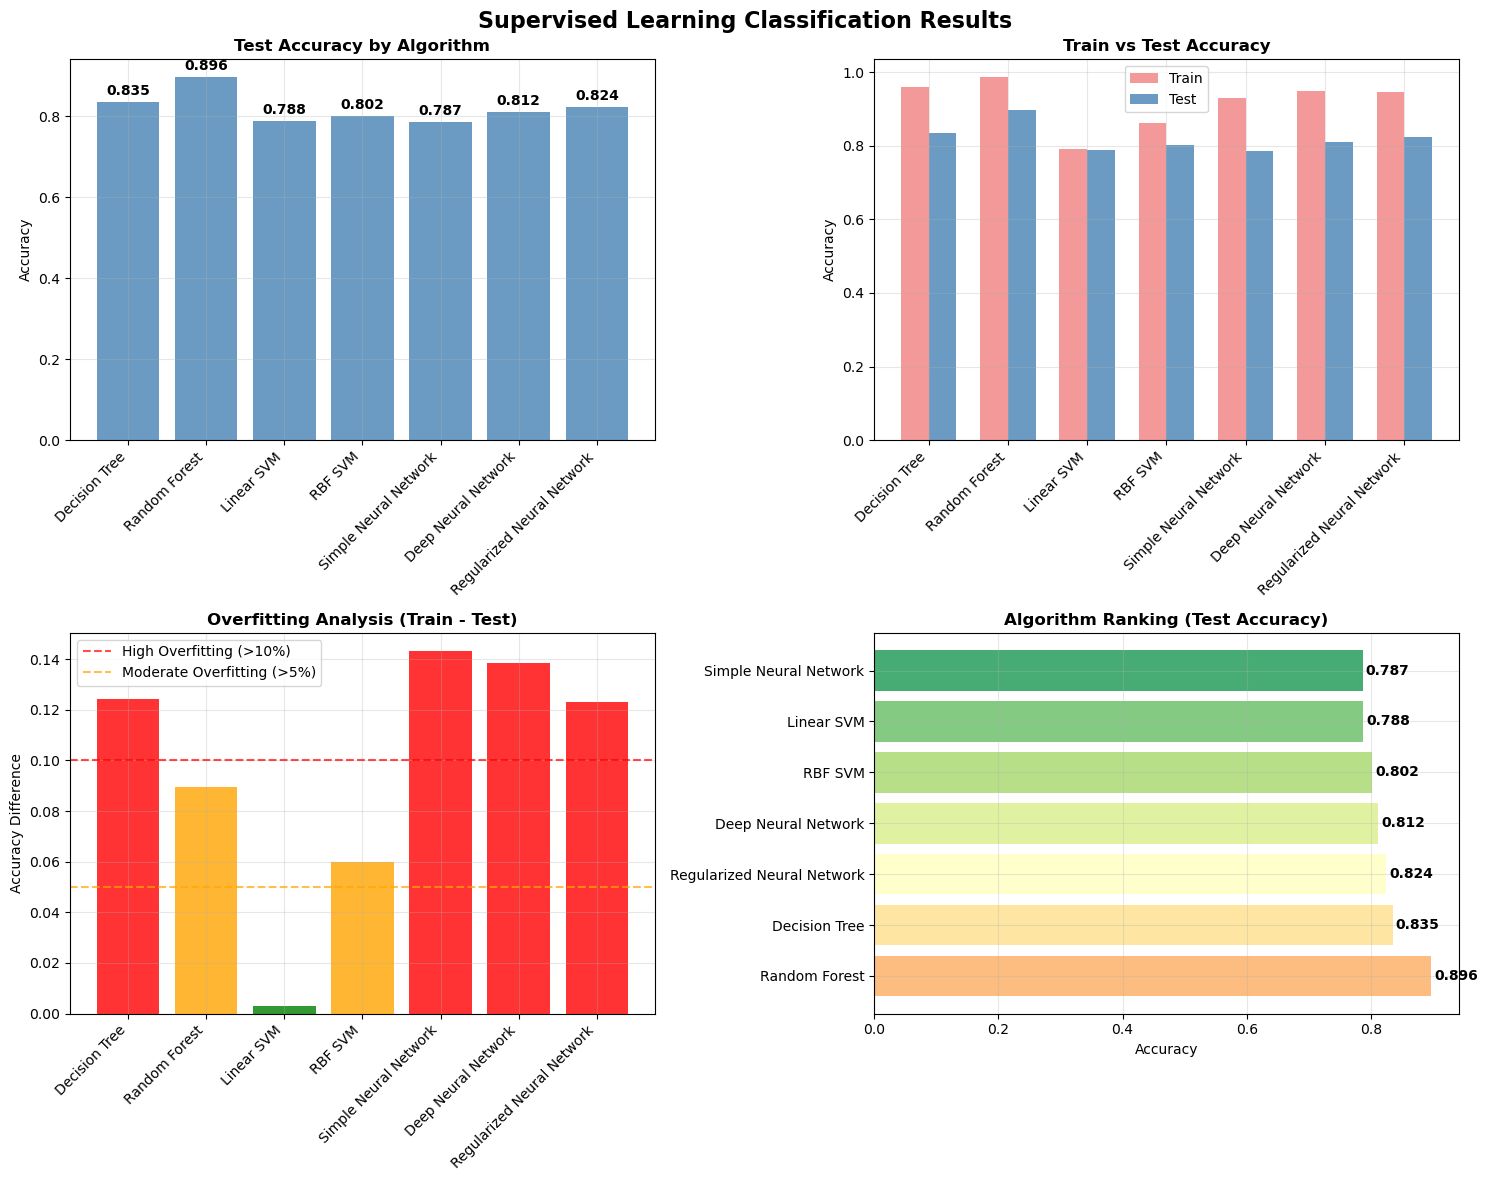


📋 DETAILED RESULTS TABLE
                 Algorithm Train Accuracy Test Accuracy Overfitting     Status
             Random Forest          0.986         0.896       0.090 🔶 Moderate
             Decision Tree          0.959         0.835       0.124    ⚠️ High
Regularized Neural Network          0.948         0.824       0.123    ⚠️ High
       Deep Neural Network          0.950         0.812       0.138    ⚠️ High
                   RBF SVM          0.862         0.802       0.060 🔶 Moderate
                Linear SVM          0.791         0.788       0.003     ✅ Good
     Simple Neural Network          0.930         0.787       0.143    ⚠️ High

📊 SUMMARY STATISTICS
🎯 Best Algorithm: Random Forest (0.896)
📈 Average Test Accuracy: 0.821
📉 Worst Algorithm: Simple Neural Network (0.787)
🔄 Accuracy Range: 0.110

⚠️ OVERFITTING ANALYSIS:
   ✅ Good Generalization: 1/7 algorithms
   🔶 Moderate Overfitting: 2/7 algorithms
   ⚠️ High Overfitting: 4/7 algorithms

🏷️ ANALYSIS BY ALGORITHM CA

In [9]:
# ============================================================
# 📈 RESULTS VISUALIZATION AND ANALYSIS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.supervised_classification import analyze_results_by_category

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    
    print("🎯 GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("=" * 50)
    
    # ============================================================
    # 1. PERFORMANCE COMPARISON BAR CHART
    # ============================================================
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Supervised Learning Classification Results', fontsize=16, fontweight='bold')
    
    # Extract data for plotting
    model_names = [r['model_name'] for r in results]
    test_accuracies = [r['test_accuracy'] for r in results]
    train_accuracies = [r['train_accuracy'] for r in results]
    
    # Bar chart of test accuracies
    bars1 = ax1.bar(range(len(model_names)), test_accuracies, alpha=0.8, color='steelblue')
    ax1.set_title('Test Accuracy by Algorithm', fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars1, test_accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # ============================================================
    # 2. TRAIN vs TEST ACCURACY COMPARISON
    # ============================================================
    
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    bars2 = ax2.bar(x_pos - width/2, train_accuracies, width, label='Train', alpha=0.8, color='lightcoral')
    bars3 = ax2.bar(x_pos + width/2, test_accuracies, width, label='Test', alpha=0.8, color='steelblue')
    
    ax2.set_title('Train vs Test Accuracy', fontweight='bold')
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ============================================================
    # 3. OVERFITTING ANALYSIS
    # ============================================================
    
    # Calculate overfitting (train - test accuracy)
    overfitting = [train - test for train, test in zip(train_accuracies, test_accuracies)]
    colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in overfitting]
    
    bars4 = ax3.bar(range(len(model_names)), overfitting, alpha=0.8, color=colors)
    ax3.set_title('Overfitting Analysis (Train - Test)', fontweight='bold')
    ax3.set_ylabel('Accuracy Difference')
    ax3.set_xticks(range(len(model_names)))
    ax3.set_xticklabels(model_names, rotation=45, ha='right')
    ax3.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='High Overfitting (>10%)')
    ax3.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting (>5%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # ============================================================
    # 4. ALGORITHM RANKING
    # ============================================================
    
    # Sort by test accuracy
    sorted_results = sorted(zip(model_names, test_accuracies), key=lambda x: x[1], reverse=True)
    sorted_names, sorted_accs = zip(*sorted_results)
    
    colors_ranking = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_names)))
    bars5 = ax4.barh(range(len(sorted_names)), sorted_accs, alpha=0.8, color=colors_ranking)
    ax4.set_title('Algorithm Ranking (Test Accuracy)', fontweight='bold')
    ax4.set_xlabel('Accuracy')
    ax4.set_yticks(range(len(sorted_names)))
    ax4.set_yticklabels(sorted_names)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars5, sorted_accs)):
        ax4.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2.,
                f'{acc:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================================
    # 5. DETAILED RESULTS TABLE
    # ============================================================
    
    print("\n📋 DETAILED RESULTS TABLE")
    print("=" * 60)
    
    # Create DataFrame for better visualization
    df_results = pd.DataFrame({
        'Algorithm': model_names,
        'Train Accuracy': [f"{acc:.3f}" for acc in train_accuracies],
        'Test Accuracy': [f"{acc:.3f}" for acc in test_accuracies],
        'Overfitting': [f"{diff:.3f}" for diff in overfitting],
        'Status': ['⚠️ High' if diff > 0.1 else '🔶 Moderate' if diff > 0.05 else '✅ Good' for diff in overfitting]
    })
    
    # Sort by test accuracy
    df_results = df_results.sort_values('Test Accuracy', ascending=False)
    print(df_results.to_string(index=False))
    
    # ============================================================
    # 6. SUMMARY STATISTICS
    # ============================================================
    
    print(f"\n📊 SUMMARY STATISTICS")
    print("=" * 30)
    print(f"🎯 Best Algorithm: {sorted_names[0]} ({sorted_accs[0]:.3f})")
    print(f"📈 Average Test Accuracy: {np.mean(test_accuracies):.3f}")
    print(f"📉 Worst Algorithm: {sorted_names[-1]} ({sorted_accs[-1]:.3f})")
    print(f"🔄 Accuracy Range: {max(test_accuracies) - min(test_accuracies):.3f}")
    
    # Count overfitting levels
    high_overfitting = sum(1 for x in overfitting if x > 0.1)
    moderate_overfitting = sum(1 for x in overfitting if 0.05 < x <= 0.1)
    good_generalization = sum(1 for x in overfitting if x <= 0.05)
    
    print(f"\n⚠️ OVERFITTING ANALYSIS:")
    print(f"   ✅ Good Generalization: {good_generalization}/{len(results)} algorithms")
    print(f"   🔶 Moderate Overfitting: {moderate_overfitting}/{len(results)} algorithms")
    print(f"   ⚠️ High Overfitting: {high_overfitting}/{len(results)} algorithms")
    
    # Analyze by category using utility function
    print(f"\n🏷️ ANALYSIS BY ALGORITHM CATEGORY:")
    analysis = analyze_results_by_category(results, verbose=False)
    
    for category, info in analysis.items():
        print(f"   📂 {category}: {info['best_algorithm']} ({info['best_accuracy']:.3f})")
    
    print(f"\n🎓 LEARNING INSIGHTS:")
    print(f"   • Classes analyzed: {selected_classes}")
    print(f"   • Cross-fold validation used for robust evaluation")
    print(f"   • {len(results)} different algorithms compared")
    print(f"   • Best performing category: {max(analysis.items(), key=lambda x: x[1]['best_accuracy'])[0]}")
    
    print(f"\n✅ Visualization complete! All plots and analysis ready.")

else:
    print("❌ No results available.")
    print("💡 Please run all the classification cells above first:")
    print("   1. Data loading and configuration")
    print("   2. Model training and validation")
    print("   3. Results analysis")
    print("\nThen re-run this cell to see the visualizations.")